<a href="https://colab.research.google.com/github/abergues/SalsaApp/blob/main/OpenPose_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Running preprocessing with OpenPose

Single file to run


*   VideoProcessing.ipynb
*   AnnotationFile.ipynb
*  Parsing-Openpose-Annotation.ipynb   



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = "/content/gdrive/MyDrive/DanceApp/"
script_path = "/content/gdrive/MyDrive/2021-DSR-Porfolio/python_scripts/"

Mounted at /content/gdrive


In [2]:
# libraries needed from outside
import os
from os.path import exists, join, basename, splitext
import sys
import glob                       # help for finding files
from re import split              # regular expression string splitter
import subprocess                 #subprocess wraps around regular os commands
import shutil                     # used for copying files in the os.


In [ ]:
# Path and variables to build OpenPose
git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):                                    ## This saves Lots of time when rerunning the whole notebook.
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`

Selecting previously unselected package libgflags2.2.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

In [ ]:
# Function to run OpenPose TODO, add this function to python script
def load_video_run_openpose():
  #requires that YOUTUBE_ID and connected variables are set. 
  #path_o = os.path.join(root_path, "input_original")+""
  #generic_file_name = "/youtube.mp4"
  #specific_file_name =  "/"+ YOUTUBE_ID + ".mp4"
  #print(generic_file_name, specific_file_name)
  
  # Check for the speed of the video
  frames_per_s = default_fps            # if everything fails there is a default value

  text = !ffprobe -v 0 -of csv=p=0 -select_streams v:0 -show_entries stream=r_frame_rate $video 
  print(text)
  frames, seconds = text[0].split("/")
  frames_per_s = int(frames) / int(seconds)
  

  print("Number of frames per second: ", frames_per_s)
  print("\n")
  if frames_per_s > 20:
    multiplikator_for_images_per_second = frames_per_s / save_frames_per_second
  else:
    multiplikator_for_images_per_second = default_fps / save_frames_per_second
  
  # cut the parts of video that we cannot use
  # !ffmpeg -y -loglevel info -i "input_original/youtube.mp4" -ss $start_mmss -t $duration "input_original/video.mp4"
  
  # detect poses
  print(f"Video for Openpose {video}") 
  op_video = output_op + "/openpose.avi"
  op_json = output_op + "/json"

  if not os.path.exists(op_json): 
    !mkdir $op_json

  !cd openpose && ./build/examples/openpose/openpose.bin --video $video --write_json $op_json --display 0  --write_video $op_video

  # convert the result into MP4
  print(" ")
  print("============================== ")
  print("Converting the stickfigure video to mp4 ")
  print(" ")

  op_video_mp4 = output_op + "/openpose.mp4"
  !ffmpeg -y -loglevel info -i $op_video $op_video_mp4
  # removing avi
  os.remove(op_video)
  print(" ")
  print("Creating single frame images ")
  print("============================== ")
  print(" ")

  ## Get only a selection of frames for labeling
  ## TODO: the numbering should match the numbering of the json files
  # save_frames_per_second = save_frames_per_second 
  # Optional to get the frames with the stick figures
  # !ffmpeg -y -loglevel info -i "output_op/$clip_name/openpose.mp4" -s $size_of_single_frame -r $save_frames_per_second -f image2 "output_op/$clip_name/frame-%06d.jpeg" 

  print(" ")
  print("============================== ")  

In [ ]:
# Function to run OpenPose TODO, add this function to python script
def run_openpose_skeleton():
  """
    Equivalent to the previuos function. Here we only generate the skeleton-frames

  """
   
  # detect poses
  print(f"Video for Openpose {video}") 
  op_frames = output_op + "/frames"

  # If frames exist, delete them
  delete_files = glob.glob(os.path.join(op_frames, "*.png"))
  
  for filePath in delete_files:
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)

  if not os.path.exists(op_frames): 
     !mkdir $op_frames

    
  !cd openpose && ./build/examples/openpose/openpose.bin --number_people_max 1 --video $video  --display 0  --disable_blending --write_images $op_frames
  
  print("Done writing frames ")  

  print("============================== ")  

In [ ]:
def rename_frames():
    
    print(os.getcwd())
    paths_frames = glob.glob(os.path.join(output_op, "frames", "*.png"))
    paths_frames = sorted(paths_frames, reverse=True)

    print("there are ", len(paths_frames), " frames files to rename")
    if len(paths_frames)>0:
      for old_file in paths_frames:
          #print(old_file)
          frame_number = old_file[-19:-13]  # counting backwards is safest, because folder names change
          #print(f"Frame {frame_number}")
          # print(f"Old name {old_file}")
          new_file_name = os.path.join(output_op, "frames") + "/frame-" + frame_number + ".png"
          # print(f"New name {new_file_name}")
          os.rename(old_file, new_file_name)

      print(" ")
      print("All frames are now renamed.")
    else:
      print("nothing to be done.")  
    print("============================== ")

    # delete old names
    # [os.remove(x) for x in paths_json]
    print(" ")

In [3]:
# Test to run external python
if not script_path in sys.path:    #otherwise will add anew with every run of script.
   sys.path.append(script_path)
   print("Added script_path to search path.")

print(sys.path)
import VideoProcessing as VP

Added script_path to search path.
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/gdrive/MyDrive/2021-DSR-Porfolio/python_scripts/']


In [ ]:
# External variables with Paths for all the functions
size_of_single_frame = "640x360"
save_frames_per_second = 5  # the number of jpgs per second
default_fps = 25     # the default frames per second of the videos, 
                     # which often is wrong  
                     # and needs to be corrected after the download
                     # so that the json and jpg files match each other.

input_video = os.path.join(root_path, "1P_input_original")

# Include later
# video_list = ['1p_JonathanB_05122021_choreo1.MOV','1p_Stef_1_05122021_Choreo1.mp4', '1p_Stef_3_05122021_chroeo1.mp4']

"""

#First set of videos
  '1p_Artur_05122021_chreo1',
 '1p_Earl_05122021_choreo1_flipped_lr.mp4',
 '1p_Eero_1_05122021_choreo1.mp4',
 '1p_Eero_4_05122021_choreo1.mp4',
 '1p_Eero_6_05122021_choreo1.mp4', 
 '1p_Eero_7_05122021_choreo1.mp4',
 '1p_Dirk_choreo1_04.12.2021.mp4',
 '1p_Heidi_07122021_choreo1_-turns.MOV',
 '1P-Person1-whole.mp4', 
 '1p_Raquelinha_05122021_choreo1.mp4',
 '1p_sarah_salsa_basics_choreo1.mp4', 
 '1p_Stef_2_05122021_Choreo1.mp4' 
# second
 "1p_Ana_c1.mp4",
 "1p_Ana_c2_20211212.mp4",
 "1p_Elizabet.mp4",
"""

# second list of videos
video_list = [   
 "1p_Jesus.mp4"  
]

"""
Videos of 1 repetition
  "1p_Jesus_Front.mp4",
 "1p_Jesus_Right.mp4",
 "1p_Vassil_1_11122021_Choreo1.mp4"

"""

for i in range(len(video_list)):
  
  # Pipeline to run openpose and get the frames
  clip_name = video_list[i]
  video_id = splitext(video_list[i])[0]
  video = os.path.join(input_video, "h920", video_id)
  video = video + "_h920.MOV"

  print(f"Processing video {video}")
  print(f"video id {video_id}")
  
  output_op = os.path.join(root_path, "output_op_1p", video_id)
  
  #run_openpose_skeleton() 
  #rename_frames()  


  # Pipeline to run Openpose and get the json

  #clip_name = video_list[i]
  #video = os.path.join(input_video, clip_name)
  #video_id = splitext(video_list[i])[0]
  #video_ext = splitext(video_list[i])[1]
  
  # Video Processing and OpenPose  
  # output_op = os.path.join(root_path, "output_op", video_id)
  #old_op = os.path.join(root_path, "output_op", video_id)
  #output_op = os.path.join(root_path, "output_op_1p", video_id)

  #if not os.path.exists(output_op): 
  #  !mkdir $output_op
  
  #print(f"Processing video {clip_name}")


  #VP.delete_outputs(video_id, root_path)
  #load_video_run_openpose()
  #VP.rename_json(video_id, root_path)

  # Creating the annotation file (it was used to create the json for output_op)
  ind_coreo = "4"
  !cp $script_path/AnnotationFile_t.py .
  !python AnnotationFile_t.py $output_op $ind_coreo

  # Instead of running this again, copy the /Annotation.json from "output_op" to "output_op_1p"
  # source_json = old_op + "/Annotation.json"
  # dest_json = output_op + "/"

  # source_steps = old_op + "/Data_steps*"
  # dest_steps = output_op + "/"

  # !cp $source_json $dest_json
  # !cp $source_steps $dest_steps
  
  # Parsing JSON and adding information from annotation
  Anot_file = output_op + "/Annotation.json" 
  !cp $script_path/Parsing-Openpose-Annotation.py .
  !python Parsing-Openpose-Annotation.py $video_id $output_op $Anot_file




Processing video /content/gdrive/MyDrive/DanceApp/1P_input_original/h920/1p_Jesus_h920.MOV
video id 1p_Jesus
Length Coreo 20
Length Tuples 40
Number of json 3576


In [ ]:
# Function to remove frames out of the coreography
def cut_frame(df_to_cut):
  # Remove all empty frames at the beginning and at the end
  index = df_to_cut.index
  conditionS = df_to_cut["status"] == "S"
  start_i = index[conditionS][0]
  conditionE = df_to_cut["status"] == "E"
  end_i = index[conditionE][len(index[conditionE])-1]

  df_to_cut = df_to_cut.loc[start_i:end_i, :]
  return df_to_cut




In [ ]:
# Creta a single Data Frame with all available data, cut and not cut
import pandas as pd

video_list = [
  '1p_Earl_05122021_choreo1_flipped_lr',
 '1p_Eero_1_05122021_choreo1',
 '1p_Eero_4_05122021_choreo1',
 '1p_Eero_6_05122021_choreo1', 
 '1p_Eero_7_05122021_choreo1',
 '1p_Dirk_choreo1_04.12.2021',
 '1p_Heidi_07122021_choreo1_-turns', 
 '1P-Person1-whole',
 '1p_Raquelinha_05122021_choreo1',
 '1p_sarah_salsa_basics_choreo1', 
 '1p_Stef_2_05122021_Choreo1' 
]

video_id_1 = ['1p_Artur_05122021_chreo1']
PATH_DATA = os.path.join(root_path, "output_op_1p", video_id_1[0], "Data.csv")
df_all = pd.read_csv(PATH_DATA)
cut_df = df_all.copy()
cut_df = cut_frame(cut_df)

for i in video_list:
  video_id = i
  PATH_DATA = os.path.join(root_path, "output_op_1p", video_id, "Data.csv")

  df = pd.read_csv(PATH_DATA)
  df_c = df.copy()
  df_c = cut_frame(df_c)

  df_all = pd.concat([df_all, df], ignore_index=True)
  cut_df = pd.concat([cut_df, df_c], ignore_index=True)



In [ ]:
print(df_all.shape)
df_all.head()



(51122, 80)


,clip_name,frame_nr,person_id,nose_x,nose_y,neck_x,neck_y,rshoulder_x,rshoulder_y,relbow_x,relbow_y,rwrist_x,rwrist_y,lshoulder_x,lshoulder_y,lelbow_x,lelbow_y,lwrist_x,lwrist_y,midhip_x,midhip_y,rhip_x,rhip_y,rknee_x,rknee_y,rankle_x,rankle_y,lhip_x,lhip_y,lknee_x,lknee_y,lankle_x,lankle_y,reye_x,reye_y,leye_x,leye_y,rear_x,rear_y,lear_x,lear_y,lbigtoe_x,lbigtoe_y,lsmalltoe_x,lsmalltoe_y,lheal_x,lheal_y,rbigtoe_x,rbigtoe_y,rsmalltoe_x,rsmalltoe_y,rheal_x,rheal_y,nose_v,neck_v,rshoulder_v,relbow_v,rwrist_v,lshoulder_v,lelbow_v,lwrist_v,midhip_v,rhip_v,rknee_v,rankle_v,lhip_v,lknee_v,lankle_v,reye_v,leye_v,rear_v,lear_v,lbigtoe_v,lsmalltoe_v,lheal_v,rbigtoe_v,rsmalltoe_v,rheal_v,label,status
0,1p_Artur_05122021_chreo1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1p_Artur_05122021_chreo1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1p_Artur_05122021_chreo1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1p_Artur_05122021_chreo1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1p_Artur_05122021_chreo1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(cut_df.shape)
cut_df.head()

(44452, 80)


,clip_name,frame_nr,person_id,nose_x,nose_y,neck_x,neck_y,rshoulder_x,rshoulder_y,relbow_x,relbow_y,rwrist_x,rwrist_y,lshoulder_x,lshoulder_y,lelbow_x,lelbow_y,lwrist_x,lwrist_y,midhip_x,midhip_y,rhip_x,rhip_y,rknee_x,rknee_y,rankle_x,rankle_y,lhip_x,lhip_y,lknee_x,lknee_y,lankle_x,lankle_y,reye_x,reye_y,leye_x,leye_y,rear_x,rear_y,lear_x,lear_y,lbigtoe_x,lbigtoe_y,lsmalltoe_x,lsmalltoe_y,lheal_x,lheal_y,rbigtoe_x,rbigtoe_y,rsmalltoe_x,rsmalltoe_y,rheal_x,rheal_y,nose_v,neck_v,rshoulder_v,relbow_v,rwrist_v,lshoulder_v,lelbow_v,lwrist_v,midhip_v,rhip_v,rknee_v,rankle_v,lhip_v,lknee_v,lankle_v,reye_v,leye_v,rear_v,lear_v,lbigtoe_v,lsmalltoe_v,lheal_v,rbigtoe_v,rsmalltoe_v,rheal_v,label,status
0,1p_Artur_05122021_chreo1,250,0.0,249.061,196.239,251.496,286.575,168.695,284.129,126.032,384.505,148.487,462.319,334.373,286.517,389.451,371.994,369.318,452.317,233.854,517.516,188.704,514.977,191.351,653.133,208.770,755.953,286.518,522.533,269.103,670.503,266.531,808.631,233.885,183.739,268.928,186.202,213.821,191.248,289.004,191.356,271.570,866.345,289.120,856.301,251.578,813.622,178.736,801.102,168.740,791.141,218.868,768.462,0.905253,0.882538,0.807618,0.828615,0.842831,0.782190,0.897228,0.907502,0.684465,0.682405,0.765624,0.853827,0.642654,0.810555,0.800686,0.884752,0.905192,0.898377,0.947265,0.790894,0.773175,0.647946,0.812466,0.850178,0.733774,basic,S
1,1p_Artur_05122021_chreo1,251,0.0,251.454,193.828,253.934,286.640,171.081,286.549,128.490,387.022,148.444,472.305,339.307,286.568,389.456,372.045,369.356,452.351,233.923,522.531,188.778,519.996,191.333,658.076,208.813,755.937,286.537,527.502,271.519,670.562,266.574,808.607,236.369,183.680,269.057,186.178,213.917,191.247,289.071,193.726,271.540,866.376,289.111,856.336,253.943,813.596,178.727,801.079,168.740,791.118,221.373,768.420,0.909779,0.866953,0.801844,0.877927,0.893125,0.780592,0.889844,0.910966,0.677615,0.683593,0.755941,0.854289,0.657238,0.834463,0.810987,0.856459,0.921658,0.875690,0.921918,0.806627,0.771766,0.630645,0.804178,0.840649,0.729915,basic,NaN
2,1p_Artur_05122021_chreo1,252,0.0,251.543,193.853,256.475,286.643,171.284,286.523,130.914,389.578,146.026,474.930,341.840,286.568,386.967,376.950,369.418,452.332,233.980,524.982,188.789,519.975,191.293,655.598,208.836,753.527,286.649,527.570,271.582,670.508,268.902,808.624,238.904,183.690,271.426,186.184,216.377,191.224,289.230,193.728,271.552,866.347,289.145,856.328,253.951,813.641,181.233,801.072,171.078,791.118,223.806,763.435,0.902302,0.842373,0.788181,0.910095,0.841959,0.780050,0.828608,0.924542,0.677021,0.691645,0.772269,0.862838,0.669216,0.815470,0.820885,0.841014,0.930492,0.882195,0.943283,0.803007,0.774799,0.633506,0.810073,0.833977,0.715198,basic,NaN
3,1p_Artur_05122021_chreo1,253,0.0,251.599,193.823,256.469,289.012,171.270,286.601,130.954,391.994,140.991,484.843,341.833,286.650,379.485,381.974,369.350,452.222,248.854,514.964,191.360,512.534,191.321,650.550,211.233,753.378,294.155,517.509,271.664,660.587,268.916,808.669,241.393,183.643,271.497,186.177,218.819,191.248,291.606,193.763,271.571,868.768,289.149,856.368,253.975,813.664,183.690,798.580,171.104,791.055,226.367,758.423,0.907760,0.847579,0.795651,0.868299,0.804663,0.782194,0.789320,0.936142,0.680573,0.677474,0.827008,0.879269,0.637561,0.762815,0.829053,0.837988,0.939281,0.876877,0.928143,0.802044,0.771636,0.628547,0.823398,0.837598,0.705927,basic,NaN
4,1p_Artur_05122021_chreo1,254,0.0,254.001,193.773,256.494,288.984,173.675,286.574,131.010,389.549,133.604,487.394,341.859,286.651,374.475,384.457,366.911,449.773,248.989,512.556,193.807,512.473,191.361,650.609,208.921,753.368,299.170,515.026,271.680,668.030,268.936,811.017,243.897,181.247,271.577,186.176,218.845,191.326,291.647,193.817,271.553,866.369,289.140,856.359,253.971,813.684,186.145,798.575,171.139,791.058,226.299,758.394,0.910799,0.842652,0.780982,0.877818,0.854954,0.777401,0.804724,0.914783,0.702386,0.657017,0.811490,0.884676,0.631724,0.772847,0.837267,0.851566,0.935580,0.841408,0.914674,0.800491,0.77497

In [ ]:
csv_file = os.path.join(root_path, "output_op_1p") + "/Data_concat.csv"
csv_file_cut = os.path.join(root_path, "output_op_1p") + "/Data_concat_cut.csv"

df_all.to_csv(csv_file , index=False)
cut_df.to_csv(csv_file_cut , index=False)

In [ ]:
# Running example with 1p Option

!mkdir output-1P
!mkdir output-1P/json

mkdir: cannot create directory ‘output-1P’: File exists


In [ ]:
inp_video_1P = os.path.join(root_path, "1P_input_original", "h920", "1p_Artur_05122021_chreo1_h920.mp4")
json_1P = "/content/output-1P/json"
video_1P = "/content/output-1P/openpose.avi"


In [ ]:
!cd openpose && ./build/examples/openpose/openpose.bin --number_people_max 1 --video $inp_video_1P --write_json $json_1P --display 0  --write_video $video_1P

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 129.377252 seconds.


In [ ]:
mp4_1P = "/content/output-1P/openpose.mp4"
!ffmpeg -y -loglevel info -i $video_1P $mp4_1P

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
## Section: Running openpose to print only the skelton

In [ ]:
!ls 

cmake-3.13.0-Linux-x86_64.tar.gz  gdrive  openpose  sample_data


In [ ]:
#!mkdir output-1P
!mkdir output-1P/frame

inp_video_1P = os.path.join(root_path, "1P_input_original", "h920", "1p_Gustavo_Front_h920.mp4")
frame_1P = "/content/output-1P/frame"
video_1P = "/content/output-1P/openpose.avi"
video_mp4 = "/content/output-1P/openpose.mp4"

!cd openpose && ./build/examples/openpose/openpose.bin --number_people_max 1 --video $inp_video_1P  --display 0  --write_video $video_1P --disable_blending --write_images $frame_1P
!ffmpeg -y -loglevel info -i $video_1P $video_mp4

mkdir: cannot create directory ‘output-1P/frame’: File exists
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
Empty frame detected, frame number 986 of 987. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
Empty frame detected, frame number 986 of 987. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
Empty frame detected, frame number 986 of 987. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
OpenPose demo successfully finished. Total time: 55.849510 seconds.
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enabl

In [ ]:
!ls /content/gdrive/MyDrive/DanceApp/1P_input_original/h920/1p_Gustavo_Front_h920.mp4


/content/gdrive/MyDrive/DanceApp/1P_input_original/h920/1p_Gustavo_Front_h920.mp4


In [ ]:
import ipywidgets as widgets

slider = widgets.IntSlider(20, min=0, max=100)
slider

IntSlider(value=20)

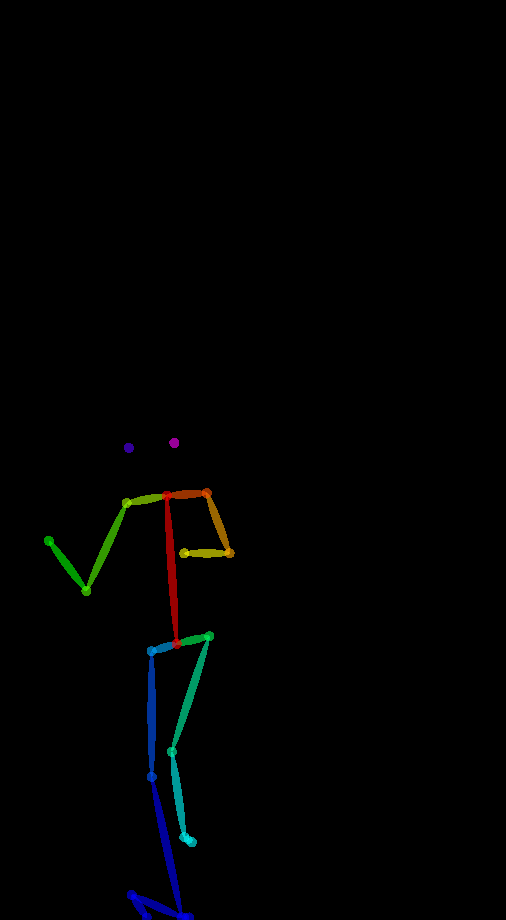

In [ ]:
# importing Image class from PIL package
from PIL import Image

# creating a object
path_frame = os.path.join("output-1P/frame", "1P-Person1-whole_h920_000000000239_rendered.png")
im = Image.open(path_frame)
im
